This python code is from https://github.com/kLabUM/rrcf. 

M. Bartos, A. Mullapudi, & S. Troutman, rrcf: Implementation of the Robust Random Cut Forest algorithm for anomaly detection on streams, in: Journal of Open Source Software, The Open Journal, Volume 4, Number 35. 2019


RRCF data are created by the C++ program.

In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Batch

Text(0.5, 0.92, 'CoDisp above 99.5th percentile')

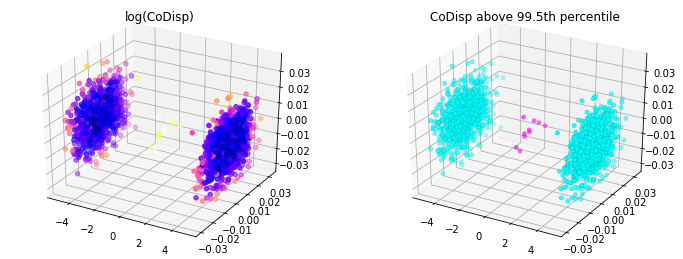

In [25]:

df = pd.read_csv('../../../../RocEdgeOut/rrcf_intro/rrcf_batch.csv',
         header=None,index_col=None )
X = np.array(df.iloc[:,0:-1])
avg_codisp = df.iloc[:,3]

threshold = avg_codisp.nlargest(n=10).min()

fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2],
                c=np.log(avg_codisp.sort_index().values),
                cmap='gnuplot2')
plt.title('log(CoDisp)')
ax = fig.add_subplot(122, projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2],
                linewidths=0.1, edgecolors='k',
                c=(avg_codisp >= threshold).astype(float),
                cmap='cool')
plt.title('CoDisp above 99.5th percentile')


Streaming

In [26]:
df = pd.read_csv('../../../../RocEdgeOut/rrcf_intro/rrcf_streaming.csv',index_col=None )

Text(0.5, 1.0, 'Sine wave with injected anomaly (red) and anomaly score (blue)')

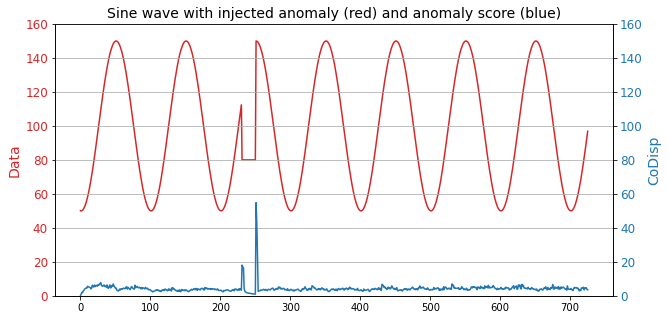

In [27]:

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(df.sin, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,160)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(df.avg_codisp .sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)


Comparison

In [28]:
df = pd.read_csv('../../../../RocEdgeOut/rrcf_intro/rrcf_comparison_codisp.csv',index_col=None,header=None )

In [31]:

from sklearn.datasets import make_moons, make_blobs
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import time

In [33]:
rng = np.random.RandomState(42)

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers



# Outlier detectors from sklean plot
anomaly_algorithms = [
    ("Robust covariance",
     EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM",
     svm.OneClassSVM(nu=outliers_fraction,
                     kernel="rbf",
                     gamma=0.1)),
    ("Isolation Forest",
     IsolationForest(contamination=outliers_fraction,
                     behaviour='new')),
    ("Local Outlier Factor",
     LocalOutlierFactor(n_neighbors=35,
                        contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0,
                    n_samples=n_inliers,
                    n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]],
               cluster_std=0.5,**blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]],
               cluster_std=[0.5, 0.5],**blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]],
               cluster_std=[1.5, .3],**blobs_params)[0],
    4. * (make_moons(n_samples=n_samples,
                     noise=.05, random_state=0)[0]
                     - np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2)
           - 0.5)]

# Add outliers to the data sets
outliers = []  # record keeping
data = []
for i in datasets:
    out = rng.uniform(low=-6, high=6,
                      size=(n_outliers, 2))
    outliers.append(out)
    data.append(np.concatenate([i, out], axis=0))



In [75]:
# rrcf
avg_codisp = []

plot_num = 1

fig = plt.figure(1, figsize=(12, 12))


<Figure size 864x864 with 0 Axes>

H:\ProgramVault\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(
H:\ProgramVault\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(
H:\ProgramVault\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(
H:\ProgramVault\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(
H:\ProgramVault\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and w

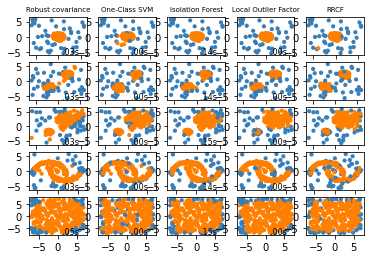

In [76]:

avg_codisp = []

for d in range(len(data)):

    tr1 = time.time()
    tr2 = time.time()

    # Compute average CoDisp
    avg_codisp_d = pd.Series(df.iloc[:,d]).dropna() 
    avg_codisp.append(avg_codisp_d)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(data[d])
        t1 = time.time()
        plt.subplot(5, len(anomaly_algorithms) + 1,plot_num)
        if d == 0:
            plt.title(name, size=7)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(data[d])
        else:
            y_pred = (algorithm.fit(data[d])
                      .predict(data[d]))

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(data[d][:, 0], data[d][:, 1], s=10,
                    color=colors[(y_pred + 1) // 2])
        plt.text(.99, .01,
                 ('%.2fs   ' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=8,
                 horizontalalignment='right')
        plot_num += 1

    plt.subplot(5, len(anomaly_algorithms) + 1, plot_num)
    avg_cod = avg_codisp[-1]
    mask = np.percentile(avg_cod, 85)
    avg_cod[avg_cod < mask] = 1
    avg_cod[avg_cod > mask] = 0
    c = ['#377eb8' if i == 0 else '#ff7f00'
         for i in avg_cod]
    plt.scatter(data[d][:,0], data[d][:,1], s=10, c=c)
    if d == 0:
        plt.title("RRCF", size=7)

        #plt.text(.99, .01,
        #         ('%.2fs' % (tr2 - tr1)).lstrip('0'),
        #          transform=plt.gca().transAxes, size=15,
        #          horizontalalignment='right')
    plot_num += 1
    
